In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import inspect 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall() 

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall() 

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_measurement_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
last_measurement_date

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
#taking the date found in my query in mysql format and converting it to a datetime 
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
#filtering by the date found in the 
last_years_prcp = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= year_ago).\
order_by(Measurement.date)

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_years_prcp_df = pd.DataFrame(last_years_prcp)
# settting the index to the date column 
last_years_prcp_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [19]:
# Sort the dataframe by date
last_years_prcp_df.sort_values(by='date', ascending=True).head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


Text(0.5, 1.0, 'Precipitation from 8/23/2016 to 8/23/2017')

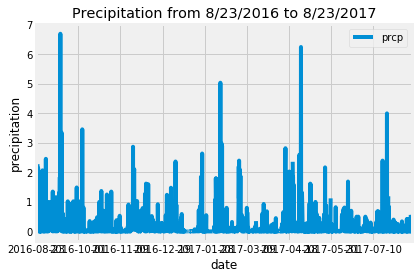

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
#plt.plot(last_years_prcp_df['date'], last_years_prcp_df['prcp'])
#plt.show

last_years_prcp_df.plot('date','prcp')
plt.xlabel("date")
plt.ylabel("precipitation")
plt.title("Precipitation from 8/23/2016 to 8/23/2017")


In [21]:
#my graph does not look good. From a previous homework I know that if my axis looks cluttred it must be because there 
#is an inconsistency in the format. 

type(last_years_prcp_df)
last_years_prcp_df.dtypes

date     object
prcp    float64
dtype: object

In [22]:
#changing the date from object back to datetime. 
#https://www.datacamp.com/community/tutorials/converting-strings-datetime-objects
last_years_prcp_df['date'] =  pd.to_datetime(last_years_prcp_df['date'])

Text(0.5, 1.0, 'Precipitation from 8/23/2016 to 8/23/2017')

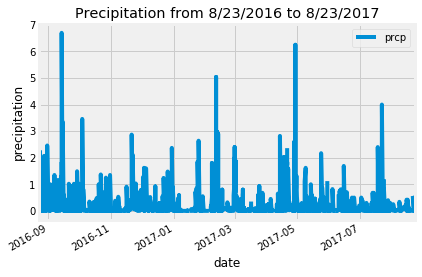

In [23]:
#graphing again
last_years_prcp_df.plot('date','prcp')
plt.xlabel("date")
plt.ylabel("precipitation")
plt.title("Precipitation from 8/23/2016 to 8/23/2017")

![precipitation](Images/precipitation.png)

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_years_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [25]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.station).count()
count_stations

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#using the chinook classroom sctivity as a guide. 
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
#finding the most active station

#using func.max to find the most active station 
#max_active_station = session.query(Measurement.station, func.max(Measurement.tobs)).\
#group_by(Measurement.station).\
#order_by(func.max(Measurement.id).desc()).all()

#max_active_station

## using func.max gives the highest tobs instead of finding the most active station. I can use this for the next step

max_active_station = most_active_stations[0]
max_active_station

('USC00519281', 2772)

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

temps


[(54.0, 85.0, 71.66378066378067)]

In [63]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelve_month_tobs = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date >= year_ago).\
filter(Measurement.station == 'USC00519281').\
group_by(Measurement.date).all()

twelve_month_tobs

In [30]:
twelve_month_tobs_df = pd.DataFrame(twelve_month_tobs, columns=["date", "temperatures"])
twelve_month_tobs_df.head()

,date,temperatures
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


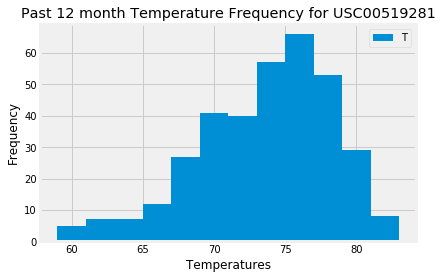

In [31]:
plt.hist(twelve_month_tobs_df["temperatures"], bins=12)
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.title("Past 12 month Temperature Frequency for USC00519281")
plt.legend("Temperatures")
plt.show()

![precipitation](Images/station-histogram.png)

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(last_measurement_date)

year_ago

('2017-08-23',)


datetime.date(2016, 8, 23)

In [34]:
last_years_temps = calc_temps("2016-08-23", "2017-08-23")
last_years_temps

[(58.0, 74.59058295964125, 87.0)]

In [35]:
last_years_temp_df = pd.DataFrame(last_years_temps, columns=["TMIN", "TAVG", "TMAX"])
last_years_temp_df

,TMIN,TAVG,TMAX
0,58.0,74.590583,87.0


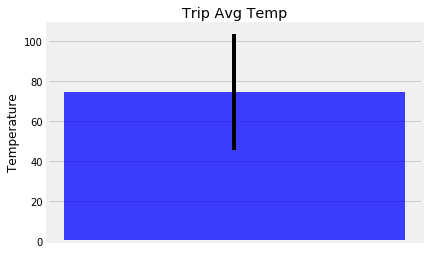

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerror = last_years_temp_df["TMAX"] - last_years_temp_df["TMIN"]

plt.bar(1, last_years_temp_df["TAVG"], yerr= yerror, alpha=0.75, color="blue")
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature")
plt.title('Trip Avg Temp')
plt.show()


Text(0.5, 1.0, 'Trip Avg Temp')

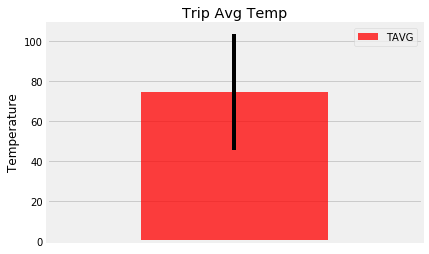

In [37]:
last_years_temp_df.plot.bar(y ="TAVG", yerr= yerror, alpha=0.75, color="red")
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature")
plt.title('Trip Avg Temp')

In [43]:
start_date = dt.date(2016, 8, 23)
end_date = dt.date(2017, 8, 23)

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

amount_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(start_date <= Measurement.date).\
filter(end_date >= Measurement.date).\
group_by(Station.station).\
order_by(Measurement.prcp.desc()).all()

print(amount_rainfall)


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [45]:
amount_rainfall_df = pd.DataFrame(amount_rainfall)
amount_rainfall_df

,station,name,latitude,longitude,elevation,prcp
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.79
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.70
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.15
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
